In [3]:
import os
import shutil
import yaml

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import argparse
import re

from src.utils.helpers import makedir
from src.models import seg_model
from src.training import push
from src.training import prune
from src.training import train_and_test as tnt

from src.utils import save
from src.utils.log import create_logger
import logging
from src.data.raman_dataset import create_raman_mask_dataloaders_from_ids

import matplotlib.pyplot as plt

# Upsampling Masks Test

A key assumption in the ProtoPNet segmentation approach is that we are able to reconstruct a good segmentation mask from a low spatial resolution probability map. Let's explore the best case to see if this is even possible in ideal conditions.

In [4]:
# config for training
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)

In [5]:
raman_id = ['E919-24_sample1_1']
val_dl = create_raman_mask_dataloaders_from_ids(
    raman_id,
    conf,
    shuffle=False,
    in_memory=True,
    is_train=False,
)

recon_diff: 4682.646484375


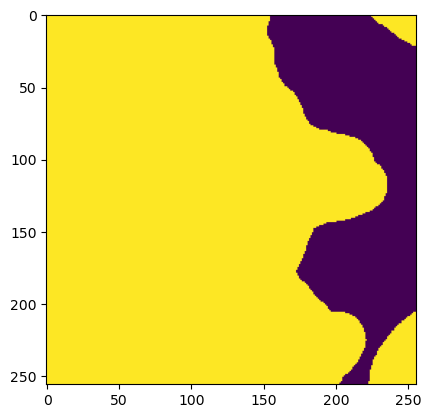

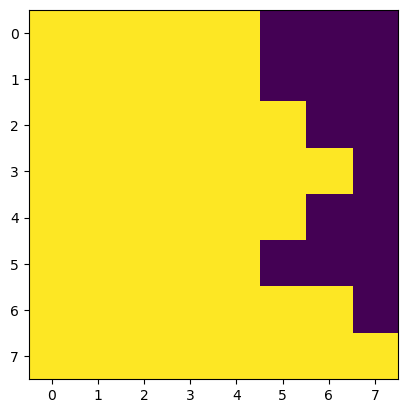

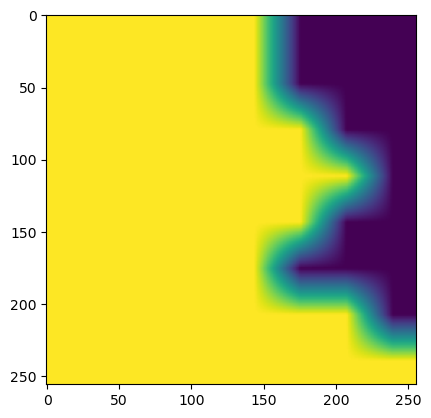

In [25]:
for x, y in val_dl:
    batch_i = 2
    if y[batch_i].sum() < 50:
        continue
    downsampled = torch.nn.functional.interpolate(
        y[batch_i].unsqueeze(0),
        size=(8, 8),
        mode="bilinear",
        # align_corners=False,
    )
    upsampled = torch.nn.functional.interpolate(
        downsampled,
        size=(y[batch_i].shape[1], y[batch_i].shape[2]),
        mode="bilinear",
        align_corners=False,
    )
    recon_diff = (y[batch_i] - upsampled[0, 0]).abs().sum()
    print(f"recon_diff: {recon_diff.item()}")
    plt.imshow(y[batch_i, 0])
    plt.show()
    plt.imshow(downsampled[0, 0])
    plt.show()
    plt.imshow(upsampled[0, 0])
    plt.show()
    break